# Particle Flow Regression Notebook
### Goal:
The goal of this notebook is to set up a baseline energyflow regression from data files created in ClustersAndTracks.ipynb

Different data sets explored:
- [x] Single track data with only tracks
- [x] Combined track and cluster
- [x] Clusters with single tracks which are high energy
- [ ] Multiple Clusters
- [ ] Multiple track

### Implementation:
Load X array of data from .npy file and target Y
Normalize data, note all normalization is done in the notebook here!
Perform regression on this data-set

#### To Do:
- [ ] Add neutral pion data in the same manner as charged pion and shuffle them
- [x] Adding track information as extra point in the point cloud
- [x] Track only regression on Pt and truthPartPt
- [x] Cluster Only Regression
- [x] Combined cluster and track regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import uproot as ur
import awkward as ak
import time as t
import copy
import scipy.constants as spc
print("Awkward version: "+str(ak.__version__))
print("Uproot Version: "+str(ur.__version__))

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu

Awkward version: 1.2.2
Uproot Version: 4.0.7


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import tensorflow as tf

In [4]:
# energyflow imports
import energyflow as ef
from energyflow.archs import PFN

### Functions

In [205]:
def tvt_num(_data, _tvt=(75, 10, 15)):
    ''' Function designed to output appropriate numbers for traning validation and testing given
    a variable length input. TVT expressed as ratios and do not need to add to 100. '''
    _tot = len(_data)
    _train, _val, _test = _tvt
    _tvt_sum = _train + _val + _test
    
    _train_rtrn = round(_train*_tot/_tvt_sum)
    _val_rtrn = round(_val*_tot/_tvt_sum)
    _test_rtrn = _tot - _train_rtrn - _val_rtrn
    
    return _train_rtrn, _val_rtrn, _test_rtrn

def normalize_input1d(arr, mask):
    len_arr = arr.shape[0]
    mean = np.repeat(np.mean(arr, where=mask), len_arr)
    std_dev = np.repeat(np.std(arr, where=mask), len_arr)
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev!=0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

def normalize_input2d(arr, mask):
    ''' Truth value is where to perform the operation, exclude False vals.
    returns: Array with the shape of arr with normalization carried out with mask '''
    len_ax1 = arr.shape[1]
    mean = np.tile(np.mean(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    std_dev = np.tile(np.std(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev != 0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

In [202]:
test_arr1 = np.tile(np.arange(6), (3,1)).astype(np.float64)
test_arr2 = np.tile(np.arange(-3,3,1), (2,1)).astype(np.float64)
test_arr3 =np.ones((1,6))
test_arr = np.concatenate((test_arr1, test_arr2, test_arr3), axis=0)

print(test_arr);print()

test_mask = test_arr != 0
print(test_mask)

test_narray = normalize_input2d(test_arr, test_mask)
print(np.std(np.arange(1,6)))
print(np.std(np.array([-3,-2,-1,1,2])));print()
print('final array!')
print(test_narray)

[[ 0.  1.  2.  3.  4.  5.]
 [ 0.  1.  2.  3.  4.  5.]
 [ 0.  1.  2.  3.  4.  5.]
 [-3. -2. -1.  0.  1.  2.]
 [-3. -2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.  1.]]

[[False  True  True  True  True  True]
 [False  True  True  True  True  True]
 [False  True  True  True  True  True]
 [ True  True  True False  True  True]
 [ True  True  True False  True  True]
 [ True  True  True  True  True  True]]
1.4142135623730951
1.854723699099141

final array!
[[ 0.         -1.41421356 -0.70710678  0.          0.70710678  1.41421356]
 [ 0.         -1.41421356 -0.70710678  0.          0.70710678  1.41421356]
 [ 0.         -1.41421356 -0.70710678  0.          0.70710678  1.41421356]
 [-1.29399328 -0.75482941 -0.21566555  0.          0.86266219  1.40182605]
 [-1.29399328 -0.75482941 -0.21566555  0.          0.86266219  1.40182605]
 [ 0.          0.          0.          0.          0.          0.        ]]


## Load Data

### Data Including Tracks
### [Eta, Phi, Energy, Layer, Track Flag. cluster_ENG_CALIB_TOT, truthPartE]

In [6]:
dat = np.load('/fast_scratch/atlas_images/v01-45/XY_tracks_small.npz')
print(dat.files)
X = dat['arr_0']
Y = dat['arr_1']
print(np.shape(X))
print(np.shape(Y))
N_events = len(X)

['arr_0', 'arr_1']
(22339, 1017, 6)
(22339, 3)


### Data Normalization

In [7]:
Energy = X[:,:,0]
Eta = np.atleast_3d(X[:,:,1])
Phi = np.atleast_3d(X[:,:,2])
rPerp = X[:,:,3]
TrackFlag = np.atleast_3d(X[:,:,4])

# split up targets
Y_eng = Y[:,0]
Y_truth = Y[:,1]
Y_clusterE = Y[:,2]

#### Energy

In [8]:
# this ensures we dont run into a runtime warning and zeros stay zeros when taking log
eng_mask = Energy > 0
Energy[eng_mask] = np.log(Energy[eng_mask])
Energy = np.atleast_3d(Energy)
print(Energy.shape)

(22339, 1017, 1)


#### rPerp

In [9]:
rPerp = np.atleast_3d(rPerp/1000)
print(rPerp.shape)

(22339, 1017, 1)


#### Reconstruct Deep Sets

In [10]:
X_deep = np.concatenate((Energy, Eta, Phi, rPerp, TrackFlag), axis=2)
print(X_deep.shape)

(22339, 1017, 5)


## Model Settings

In [11]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = tvt_num(X_deep, _tvt=(75, 10, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 40
batch_size = 400

train -- val -- test
16754 -- 2234 -- 3351


#### Train/Val/Test Split

In [12]:
(s_train, s_val, s_test,
 y_eng_train, y_eng_val, y_eng_test) = ef.utils.data_split(X_deep, Y_eng, val=val, test=test)

# Print out tensor shapes
print(np.shape(s_train))
print(np.shape(y_eng_train))

(16754, 1017, 5)
(16754,)


### Build Architecture

In [13]:
pfn = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

## Train Model

In [97]:
pfn.fit(s_train, y_eng_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(s_val, y_eng_val),
        verbose=1)

Epoch 1/40
42/42 [==============================] - 2s 31ms/step - loss: 109130.7785 - val_loss: 95152.7266
Epoch 2/40
42/42 [==============================] - 1s 25ms/step - loss: 85249.8841 - val_loss: 90307.2188
Epoch 3/40
42/42 [==============================] - 1s 25ms/step - loss: 83372.4315 - val_loss: 75974.6094
Epoch 4/40
42/42 [==============================] - 1s 25ms/step - loss: 67811.9526 - val_loss: 59170.5430
Epoch 5/40
42/42 [==============================] - 1s 25ms/step - loss: 59436.7096 - val_loss: 67672.9766
Epoch 6/40
42/42 [==============================] - 1s 26ms/step - loss: 55238.5234 - val_loss: 51382.4648
Epoch 7/40
42/42 [==============================] - 1s 27ms/step - loss: 46020.7291 - val_loss: 51151.2461
Epoch 8/40
42/42 [==============================] - 1s 29ms/step - loss: 50256.2218 - val_loss: 49368.7734
Epoch 9/40
42/42 [==============================] - 1s 27ms/step - loss: 46057.0401 - val_loss: 49730.2148
Epoch 10/40
42/42 [=================

### Predictions

In [105]:
preds = pfn.predict(s_test, batch_size=1000)
preds = np.reshape(preds, test)
print(preds.shape)

(3351,)


## Analytics

<ipython-input-111-e94b61a280a4>:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist2d(y_eng_test, preds/y_eng_test, bins=[xbin,ybin], norm=LogNorm())


<Figure size 799.992x599.976 with 0 Axes>

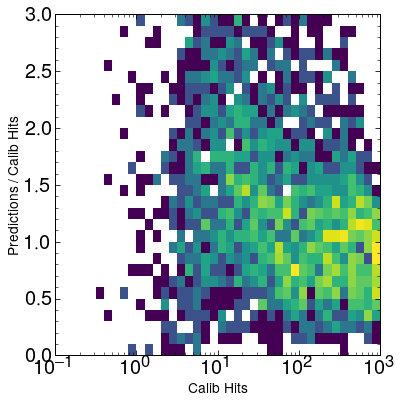

In [111]:
plt.cla(); plt.clf()

xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)

fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist2d(y_eng_test, preds/y_eng_test, bins=[xbin,ybin], norm=LogNorm())
plt.xlabel('Calib Hits', fontsize=14)
plt.ylabel('Predictions / Calib Hits', fontsize=14)
plt.xscale('log')
# plt.tight_layout()
# plt.savefig('Plots/Base_Regression_response_hist_tracks_2021-06-03.png', format='png')
plt.show()

## Cluster Only

In [203]:
dat = np.load('/fast_scratch/atlas_images/v01-45/XY_clustersOnly_med.npz')
print(dat.files)
X_clustOnly = dat['arr_0']
Y_clustOnly = dat['arr_1']
print(np.shape(X_clustOnly))
print(np.shape(Y_clustOnly))
N_events = len(X_clustOnly)

['arr_0', 'arr_1']
(68516, 929, 5)
(68516,)


### Visualize Input Data

(68516,)


<Figure size 799.992x599.976 with 0 Axes>

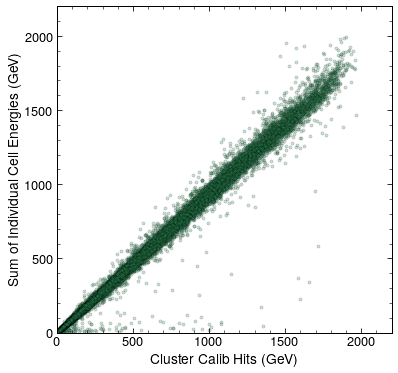

In [77]:
cluster_E_sum = np.sum(X_clustOnly[:,:,0], axis=1)
print(cluster_E_sum.shape)
plt.cla();plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor(color='white')
plt.scatter(Y_clustOnly, cluster_E_sum, s=10,edgecolor='black', color='seagreen', alpha=.25)
plt.xlabel('Cluster Calib Hits (GeV)', fontsize=14)
plt.ylabel('Sum of Individual Cell Energies (GeV)', fontsize=14)
plt.xlim(0,2200)
plt.ylim(0,2200)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/ClusterOnly_RegressionInputs_2021-06-09.png', format='png')
plt.show()

### Normalize Target

In [213]:
print(Y_clustOnly.shape)
Y_cO_mask = Y_clustOnly > .1
print('Any target values zero: '+repr(np.any(Y_cO_mask)))
nCData = np.count_nonzero(Y_cO_mask)
print('number after cut: '+str(nCData))

(68516,)
Any target values zero: True
number after cut: 63459


In [254]:
Y_cO = np.ndarray.copy(Y_clustOnly[Y_cO_mask])
Y_nonzero = Y_cO != 0
Y_cO[Y_nonzero] = np.log(Y_cO[Y_nonzero])
Y_cOn = np.ndarray.copy(normalize_input1d(Y_cO, Y_nonzero))
# Y_clustOnly = np.atleast_2d(Y_clustOnly).transpose()
print(Y_cO.shape)

(63459,)


### Data Normalization

In [237]:
## DEEP COPY ARRAY ##
X_cO = np.ndarray.copy(X_clustOnly[Y_cO_mask,:,0:4])
X_cO_norm =np.ndarray.copy(X_clustOnly[Y_cO_mask,:,0:4])
print(X_cO.shape)

(63459, 929, 4)


In [238]:
## Normalize rPerp to 1/1000
rPerp_mask = X_cO[:,:,3] != 0
X_cO[:,:,3][rPerp_mask] = X_cO[:,:,3][rPerp_mask]/1000

## Energy Values that are not zero!
E_nonZeroMask = X_cO[:,:,0] != 0
X_cO[:,:,0][E_nonZeroMask] = np.log(X_cO[:,:,0][E_nonZeroMask])

## Eta and Phi
eta_mask = X_cO[:,:,1] != 0
X_cO[:,:,1][eta_mask] = X_cO[:,:,1][eta_mask]

phi_mask = X_cO[:,:,2] != 0
X_cO[:,:,2][phi_mask] = X_cO[:,:,2][phi_mask]

#### New Normalization Scheme

In [239]:
## Normalize rPerp to 1/1000
rPerp_maskn = X_cO_norm[:,:,3] != 0
X_cO_norm[:,:,3] = normalize_input2d(X_cO_norm[:,:,3], rPerp_maskn)

## Energy Values that are not zero!
E_nonZeroMaskn = X_cO_norm[:,:,0] != 0
X_cO_norm[:,:,0][E_nonZeroMaskn] = np.log(X_cO_norm[:,:,0][E_nonZeroMaskn])
X_cO_norm[:,:,0] = normalize_input2d(X_cO_norm[:,:,0], E_nonZeroMaskn)

## Eta and Phi
eta_maskn = X_cO_norm[:,:,1] != 0
X_cO_norm[:,:,1] = normalize_input2d(X_cO_norm[:,:,1], eta_maskn)

phi_maskn = X_cO_norm[:,:,2] != 0
X_cO_norm[:,:,2] = normalize_input2d(X_cO_norm[:,:,2], phi_maskn)

### Histograms of Inputs

<Figure size 799.992x599.976 with 0 Axes>

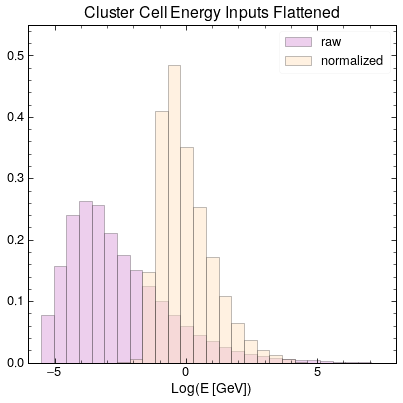

<Figure size 799.992x599.976 with 0 Axes>

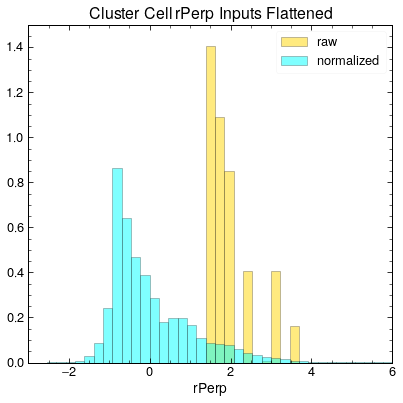

In [263]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,8, 30, endpoint=True)
plt.hist(X_cO[:,:,0][E_nonZeroMask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black',
         label='raw')
plt.hist(X_cO_norm[:,:,0][E_nonZeroMaskn], color='bisque', bins=ebins, density=True, alpha=.5, edgecolor='black',
         label='normalized')
plt.title('Cluster Cell Energy Inputs Flattened', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Regression_Plots/CLO_EnergyInputs_normalization_2020-06-21.png', format='png')
plt.show()

#########
## ETA ##
#########
# plt.cla(); plt.clf()
# fig = plt.figure(figsize=(6,6))
# etabins = np.linspace(-5,5,40, endpoint=True)
# plt.hist(X_cO[:,:,1][eta_mask], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black',
#          label='raw')
# plt.hist(X_cO_norm[:,:,1][eta_maskn], color='chartreuse', bins=etabins, density=True, alpha=.5, edgecolor='black',
#          label='normalized')
# plt.title('Cluster Cell Eta Inputs Flattened', fontsize=16)
# plt.xlabel('Eta', fontsize=14)
# plt.xlim(np.min(etabins),np.max(etabins))
# plt.ylim(0,.55)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.legend(loc='upper right')
# # plt.tight_layout()
# # plt.savefig('Regression_Plots/CLO_EtaInputs_normalization_2020-06-20.png', format='png')
# plt.show()

#########
## PHI ##
#########
# plt.cla(); plt.clf()
# fig = plt.figure(figsize=(6,6))
# phibins = np.linspace(-5,5,40, endpoint=True)
# plt.hist(X_cO[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black',
#          label='raw')
# plt.hist(X_cO_norm[:,:,2][phi_maskn], color='teal', bins=phibins, density=True, alpha=.5, edgecolor='black',
#          label='normalized')
# plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
# plt.xlabel('Phi', fontsize=14)
# plt.xlim(np.min(phibins),np.max(phibins))
# plt.ylim(0,.55)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.legend(loc='upper right')
# # plt.tight_layout()
# # plt.savefig('Regression_Plots/CLO_PhiInputs_normalization_2020-06-20.png', format='png')
# plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-3,6,40, endpoint=True)
plt.hist(X_cO[:,:,3][rPerp_mask], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black',
         label='raw')
plt.hist(X_cO_norm[:,:,3][rPerp_maskn], color='aqua', bins=Rbins, density=True, alpha=.5, edgecolor='black',
         label='normalized')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,1.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Regression_Plots/CLO_rPerpInputs_normalization_2020-06-21.png', format='png')
plt.show()


## Model Building & Settings

In [253]:
# EFN regression example uses 75/10/15 split for 100,000 samples
c_train, c_val, c_test = tvt_num(X_cO, _tvt=(75, 10, 15))
print('train -- val -- test')
print(str(c_train)+' -- '+str(c_val)+' -- '+str(c_test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 60
batch_size = 50

train -- val -- test
47594 -- 6346 -- 9519


#### TVT Split

In [255]:
print('Totals for inputs')
print(X_cO.shape)
print(Y_cO.shape);print()
(cl_train, cl_val, cl_test,
 y_cl_train, y_cl_val, y_cl_test) = ef.utils.data_split(X_cO, Y_cO, val=c_val, test=c_test)
(cln_train, cln_val, cln_test,
 y_cln_train, y_cln_val, y_cln_test) = ef.utils.data_split(X_cO_norm, Y_cOn, val=c_val, test=c_test)

print('Totals for training data')
print(np.shape(cl_train))
print(np.shape(y_cl_train))

Totals for inputs
(63459, 929, 4)
(63459,)

Totals for training data
(47594, 929, 4)
(47594,)


#### Build Model

In [90]:
pfnC = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_112 (Activation)     (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_112[0][0]             
___________________________________________________________________________________________

## Train Single Model, no loop

In [91]:
history = pfnC.fit(cl_train, y_cl_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(cl_val, y_cl_val),
        verbose=1)

Epoch 1/60
952/952 [==============================] - 10s 10ms/step - loss: 1703.7777 - val_loss: 5.1167
Epoch 2/60
952/952 [==============================] - 4s 5ms/step - loss: 3.8851 - val_loss: 3.5508
Epoch 3/60
952/952 [==============================] - 5s 5ms/step - loss: 14.1715 - val_loss: 2.7242
Epoch 4/60
952/952 [==============================] - 4s 5ms/step - loss: 2.4499 - val_loss: 1.4777
Epoch 5/60
952/952 [==============================] - 5s 5ms/step - loss: 2.3676 - val_loss: 2.2433
Epoch 6/60
952/952 [==============================] - 4s 5ms/step - loss: 2.5639 - val_loss: 0.8950
Epoch 7/60
952/952 [==============================] - 4s 5ms/step - loss: 1.0233 - val_loss: 0.5068
Epoch 8/60
952/952 [==============================] - 4s 5ms/step - loss: 35.2867 - val_loss: 0.6419
Epoch 9/60
952/952 [==============================] - 4s 5ms/step - loss: 0.5848 - val_loss: 0.4905
Epoch 10/60
952/952 [==============================] - 4s 5ms/step - loss: 0.3978 - val_loss:

#### Train Model in Loop

In [256]:
history_list_raw = []
history_list_norm = []
for i in range(5):
    print();print();print('BUILDING MODEL '+str(i)+' RAW');print();print()
    raw_model = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])
    print();print();print('TRAINING MODEL '+str(i)+' RAW');print();print()
    my_history_raw = raw_model.fit(cl_train, y_cl_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(cl_val, y_cl_val),
        verbose=1)
    history_list_raw.append(my_history_raw)
    
    print();print();print('BUILDING MODEL '+str(i)+' NORMALIZED');print();print()
    norm_model = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])
    print();print();print('TRAINING MODEL '+str(i)+' NORMALIZED');print();print()
    my_history_norm = norm_model.fit(cln_train, y_cln_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(cln_val, y_cln_val),
        verbose=1)
    history_list_norm.append(my_history_norm)



BUILDING MODEL 0 RAW


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_119 (Activation)     (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_119[0][0]             
__________________________________________________________________

<Figure size 799.992x599.976 with 0 Axes>

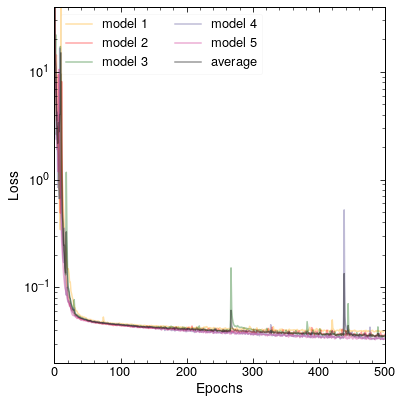

<Figure size 799.992x599.976 with 0 Axes>

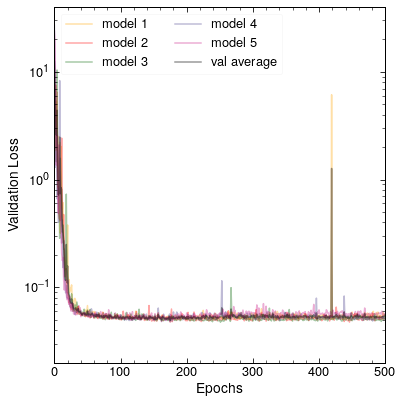

<Figure size 799.992x599.976 with 0 Axes>

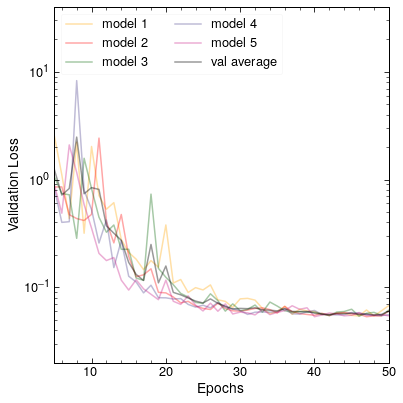

In [72]:
plt.cla(); plt.clf()
colors1 = ['orange', 'red', 'darkgreen', 'darkslateblue', 'mediumvioletred']
colors2 = ['chocolate', 'olivedrab', 'steelblue', 'seagreen', 'indigo']
model_num = ['1','2','3','4','5']

loss_av = np.zeros(np.shape(history_list[0].history['loss']))
fig = plt.figure(figsize=(6,6))
for i in range(5):
    plt.plot(history_list[i].history['loss'], color=colors1[i], alpha=.35,
            label='model '+model_num[i])
    loss_av = np.add(loss_av, history_list[i].history['loss'])
loss_av = loss_av/5
plt.plot(loss_av, color='black', alpha=.4, label='average')
plt.yscale('log')
plt.ylim(.02,40)
plt.yticks(fontsize=13)
plt.xlim(0,500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper left', ncol=2)
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_losses_5runs_500epoch_50batch_2021-06-18.png', format='png')
plt.show()

plt.cla(); plt.clf()
val_loss_av = np.zeros(np.shape(history_list[0].history['val_loss']))
fig = plt.figure(figsize=(6,6))
for i in range(5):
    plt.plot(history_list[i].history['val_loss'], color=colors1[i], alpha=.35,
            label='model '+model_num[i])
    val_loss_av = np.add(val_loss_av, history_list[i].history['val_loss'])
val_loss_av = val_loss_av/5
plt.plot(val_loss_av, color='black', alpha=.4, label='val average')
plt.yscale('log')
plt.ylim(.02,40)
plt.yticks(fontsize=13)
plt.xlim(0,500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Loss', fontsize=14)
plt.legend(loc='upper left', ncol=2)
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_val_losses_5runs_500epoch_50batch_2021-06-18.png', format='png')
plt.show()

plt.cla(); plt.clf()
val_loss_av = np.zeros(np.shape(history_list[0].history['val_loss']))
fig = plt.figure(figsize=(6,6))
for i in range(5):
    plt.plot(history_list[i].history['val_loss'], color=colors1[i], alpha=.35,
            label='model '+model_num[i])
    val_loss_av = np.add(val_loss_av, history_list[i].history['val_loss'])
val_loss_av = val_loss_av/5
plt.plot(val_loss_av, color='black', alpha=.4, label='val average')
plt.yscale('log')
plt.ylim(.02,40)
plt.yticks(fontsize=13)
plt.xlim(5,50)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Loss', fontsize=14)
plt.legend(loc='upper left', ncol=2)
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_val_losses_5runs_500epoch_50batch_zoomed_2021-06-18.png', format='png')
plt.show()

#### Input Comparison

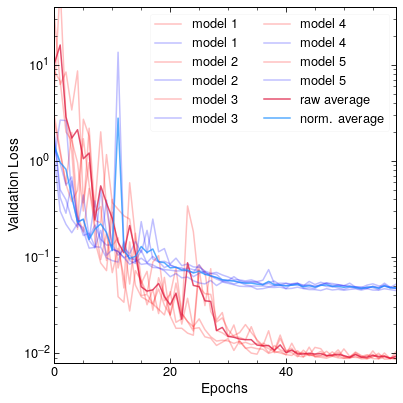

In [262]:
val_loss_av_raw = np.zeros(np.shape(history_list_raw[0].history['val_loss']))
val_loss_av_norm = np.zeros(np.shape(history_list_norm[0].history['val_loss']))
fig = plt.figure(figsize=(6,6))

for i in range(5):
    plt.plot(history_list_raw[i].history['val_loss'], color='red', alpha=.25,
            label='model '+model_num[i])
    plt.plot(history_list_norm[i].history['val_loss'], color='blue', alpha=.25,
            label='model '+model_num[i])
    val_loss_av_raw = np.add(val_loss_av_raw, history_list_raw[i].history['val_loss'])
    val_loss_av_norm = np.add(val_loss_av_norm, history_list_norm[i].history['val_loss'])
val_loss_av_raw = val_loss_av_raw/5
val_loss_av_norm = val_loss_av_norm/5
plt.plot(val_loss_av_raw, color='crimson', alpha=.75, label='raw average')
plt.plot(val_loss_av_norm, color='dodgerblue', alpha=.75, label='norm. average')
plt.yscale('log')
plt.ylim(.008,40)
plt.yticks(fontsize=13)
plt.xlim(0,59)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Loss', fontsize=14)
plt.legend(loc='upper right', ncol=2)
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_val_losses_5runs_60epoch_50batch_normVsRaw_2021-06-21.png', format='png')
plt.show()

### Predictions

In [93]:
cl_preds = pfnC.predict(cl_test, batch_size=100)
print(cl_test.shape)
print(cl_preds.shape)

(9519, 929, 4)
(9519, 1)


#### Plot Inputs and Target

<Figure size 799.992x599.976 with 0 Axes>

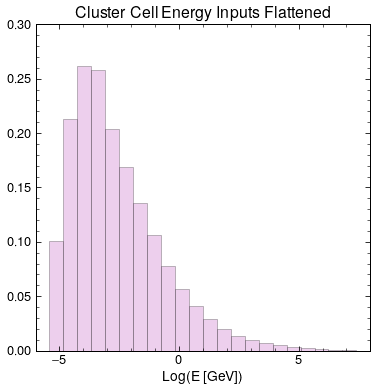

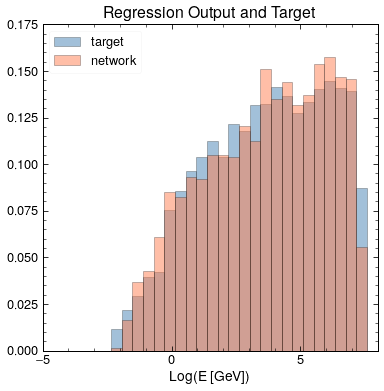

In [94]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(-4,8,30, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(y_cl_test, color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(cl_preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(-5,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly-output-wTarget-regression-log_2021-06-10.png', format='png')
plt.show()

### Analytics

#### Loss

dict_keys(['loss', 'val_loss'])


<Figure size 799.992x599.976 with 0 Axes>

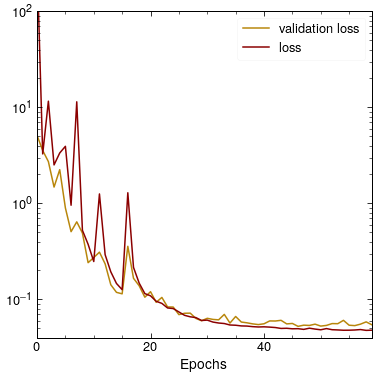

In [100]:
print(history.history.keys())
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], color='darkgoldenrod', label='validation loss')
plt.plot(history.history['loss'], color='darkred', label='loss')
plt.yscale('log')
plt.ylim(.04,1e2)
plt.yticks(fontsize=13)
plt.xlim(0,59)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right')
# plt.tight_layout()
# plt.savefig('Regression_Plots/clusterOnly_losses_log_2021-06-10.png', format='png')
plt.show()

#### 2-D Histogram

(9519,)
(9519, 1)
(9519,) (9519,)


<Figure size 799.992x599.976 with 0 Axes>

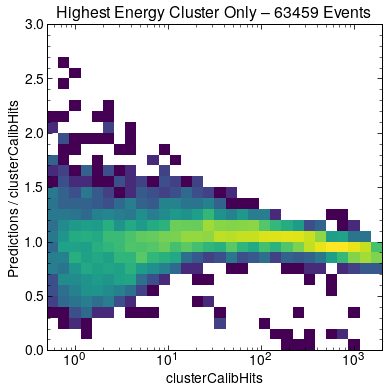

In [101]:
print(y_cl_test.shape)
print(cl_preds.shape)
clusterHits = np.exp(y_cl_test.flatten())
networkPreds = np.exp(cl_preds.flatten())
print(repr(clusterHits.shape)+' '+repr(networkPreds.shape))

ybin = np.arange(0., 3.1, 0.1)
xbin = np.logspace(np.log10(.5), np.log10(2000), num=len(ybin), endpoint=True, base=10.0)

plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist2d(clusterHits, networkPreds/clusterHits, bins=[xbin,ybin], norm=LogNorm())
plt.title('Highest Energy Cluster Only -- 63459 Events', fontsize=16)
plt.xlabel('clusterCalibHits', fontsize=14)
plt.ylabel('Predictions / clusterCalibHits', fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.tight_layout()
# plt.savefig('Regression_Plots/SingleCluster_regression_gt_pt1GeV_log_normal_training_2021-06-18.png', format='png')
plt.show()

#### Resolution Plots

<Figure size 799.992x599.976 with 0 Axes>

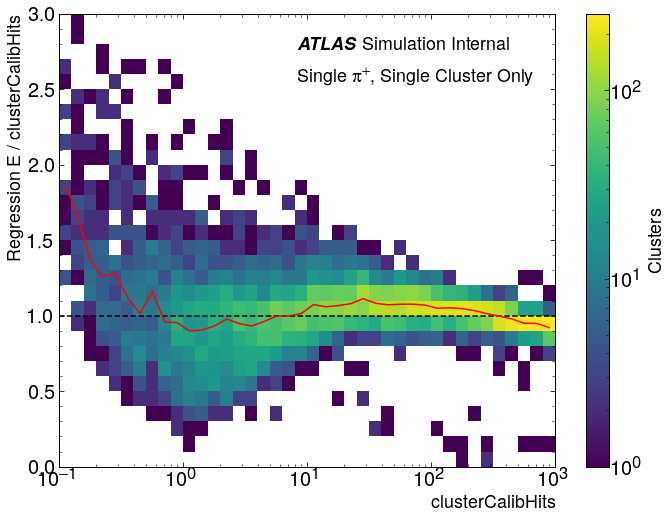

In [102]:
plotpath = '/home/russbate/MLPionCollaboration/LCStudies/clusters/Regression_Plots/'
Pt_center, Pt_Single = ru.responsePlot(clusterHits, 
                      networkPreds/clusterHits,
                      figfile = plotpath+'singleCluster_responsePlot_2021-06-18.png', statistic = 'median',
                      xlabel = 'clusterCalibHits', ylabel = 'Regression E / clusterCalibHits',
                      atlas_x = 0.48, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.48, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Cluster Only'}])

#### Scatter Plot

<Figure size 799.992x599.976 with 0 Axes>

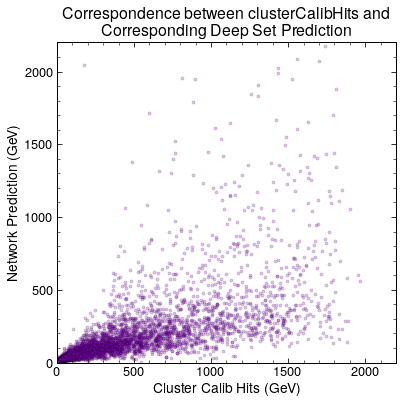

In [66]:
plt.cla();plt.clf()

fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor(color='white')
plt.scatter(clusterHits, networkPreds, s=10, edgecolor='black', color='darkviolet', alpha=.25)
plt.title('Correspondence between clusterCalibHits and\n Corresponding Deep Set Prediction',
         fontsize=16)
plt.xlabel('Cluster Calib Hits (GeV)', fontsize=14)
plt.ylabel('Network Prediction (GeV)', fontsize=14)
plt.xlim(0,2200)
plt.ylim(0,2200)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/ClusterOnly_NetworkPredictions_scatter_Log_better_2021-06-10.png', format='png')
plt.show()

## Track Only

In [14]:
dat = np.load('/fast_scratch/atlas_images/v01-45/XY_tracksOnly_Pt_distributed_med.npz')
print(dat.files)
X_tracksOnly = dat['arr_0']
Y_tracksOnly = dat['arr_1']
print(np.shape(X_tracksOnly))
print(np.shape(Y_tracksOnly))
N_events = len(X_tracksOnly)

['arr_0', 'arr_1']
(69414, 6, 5)
(69414,)


### Data Normalization

In [15]:
t_Pt = X_tracksOnly[:,:,0]
t_Eta = np.atleast_3d(X_tracksOnly[:,:,1])
t_Phi = np.atleast_3d(X_tracksOnly[:,:,2])
t_rPerp = X_tracksOnly[:,:,3]

Y_trthPt = Y_tracksOnly

#### Energy

In [16]:
# this ensures we dont run into a runtime warning and zeros stay zeros when taking log
Pt_mask = t_Pt > 0
t_Pt[Pt_mask] = np.log(t_Pt[Pt_mask])
t_Pt = np.atleast_3d(t_Pt)
print(t_Pt.shape)

(69414, 6, 1)


#### rPerp

In [17]:
t_rPerp = np.atleast_3d(t_rPerp/1000)
print(t_rPerp.shape)

(22339, 1017, 1)


#### Target

In [190]:
# this ensures we dont run into a runtime warning and zeros stay zeros when taking log
Y_Pt_mask = Y_trthPt > 0
Y_trthPt[Y_Pt_mask] = np.log(Y_trthPt[Y_Pt_mask])
print('Zero Pt found: '+repr(np.any(Y_Pt_mask)))
# Y_trthPt = np.atleast_2d(Y_trthPt).transpose()
print(Y_trthPt.shape)

Zero Pt found: True
(69414,)


#### Track Deep Set

In [19]:
XtO_deep = np.concatenate((t_Pt, t_Eta, t_Phi, t_rPerp), axis=2)
print(XtO_deep.shape)

(69414, 6, 4)


### Model Settings

In [20]:
# EFN regression example uses 75/10/15 split for 100,000 samples
t_train, t_val, t_test = tvt_num(XtO_deep, _tvt=(75, 10, 15))
print('train -- val -- test')
print(str(t_train)+' -- '+str(t_val)+' -- '+str(t_test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 100
batch_size = 600

train -- val -- test
52060 -- 6941 -- 10413


#### TVT Split

In [21]:
(t_train, t_val, t_test,
 y_pt_train, y_pt_val, y_pt_test) = ef.utils.data_split(XtO_deep, Y_trthPt, val=t_val, test=t_test)

# Print out tensor shapes
print(np.shape(t_train))
print(np.shape(y_pt_train))

(52060, 6, 4)
(52060,)


### Build Architecture

In [22]:
pfnT = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

### Train Model

In [23]:
pfnT.fit(t_train, y_pt_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(t_val, y_pt_val),
        verbose=1)

Epoch 1/100
87/87 [==============================] - 6s 11ms/step - loss: 19.7431 - val_loss: 0.1761
Epoch 2/100
87/87 [==============================] - 0s 4ms/step - loss: 0.1284 - val_loss: 0.1257
Epoch 3/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0931 - val_loss: 0.1188
Epoch 4/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0851 - val_loss: 0.1037
Epoch 5/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0801 - val_loss: 0.1044
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0759 - val_loss: 0.0990
Epoch 7/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0775 - val_loss: 0.0977
Epoch 8/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0845 - val_loss: 0.0950
Epoch 9/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0773 - val_loss: 0.0955
Epoch 10/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0830 - val_loss: 0.0934
Epoch 1

#### Predictions

(10413, 1)


<Figure size 799.992x599.976 with 0 Axes>

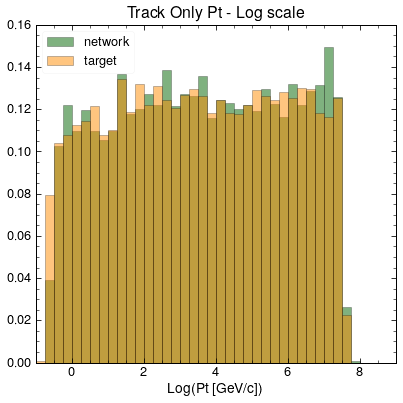

In [179]:
t_preds = pfnT.predict(t_test, batch_size=1000)
print(t_preds.shape)
bins = np.arange(-1,8.25,.25)

plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist(t_preds.flatten(), bins=bins, density=True, color='darkgreen', alpha=.5, edgecolor='black', label='network')
plt.hist(y_pt_test, bins=bins, density=True, color='darkorange', alpha=.5, edgecolor='black', label='target')
plt.title('Track Only Pt - Log scale', fontsize=16)
plt.xlabel('Log(Pt [GeV/c])', fontsize=14)
plt.xlim(-1,9)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/Inputs-and-outputs-to-trackPt-regression-log_2021-06-10.png', format='png')
plt.show()

### Analytics

<Figure size 799.992x599.976 with 0 Axes>

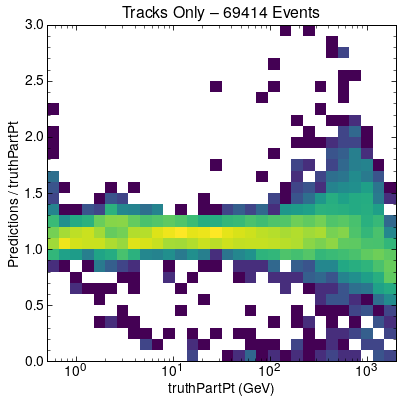

In [36]:
pt_pred = np.exp(t_preds.flatten())
pt_trth = np.exp(y_pt_test.flatten())

ybin = np.arange(0., 3.1, 0.1)
xbin = np.logspace(np.log10(.5), np.log10(2000), num=len(ybin), endpoint=True, base=10.0)

plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist2d(pt_trth, pt_pred/pt_trth, bins=[xbin,ybin], norm=LogNorm())
plt.title('Tracks Only -- 69414 Events', fontsize=16)
plt.xlabel('truthPartPt (GeV)', fontsize=14)
plt.ylabel('Predictions / truthPartPt', fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.tight_layout()
# plt.savefig('Regression_Plots/Pt_TrackOnly_mediumRoot_2021-06-08.png', format='png')
plt.show()

In [202]:
tr_Pt_test = t_test[:,:,0].astype(np.float128)
tr_Pt_mask = tr_Pt_test != 0

print(repr(tr_Pt_test.shape)+' '+repr(tr_Pt_mask.shape))
tr_Pt_test[trck_tst_mask] = np.exp(tr_Pt_test[trck_tst_mask])

tr_Pt_test = np.sum(tr_Pt_test, axis=1)
print(tr_Pt_test.shape)

(10413, 6) (10413, 6)
(10413,)


<ipython-input-202-f82aab97ac96>:5: RuntimeWarning: overflow encountered in exp
  tr_Pt_test[trck_tst_mask] = np.exp(tr_Pt_test[trck_tst_mask])


#### Response Plots

<Figure size 799.992x599.976 with 0 Axes>

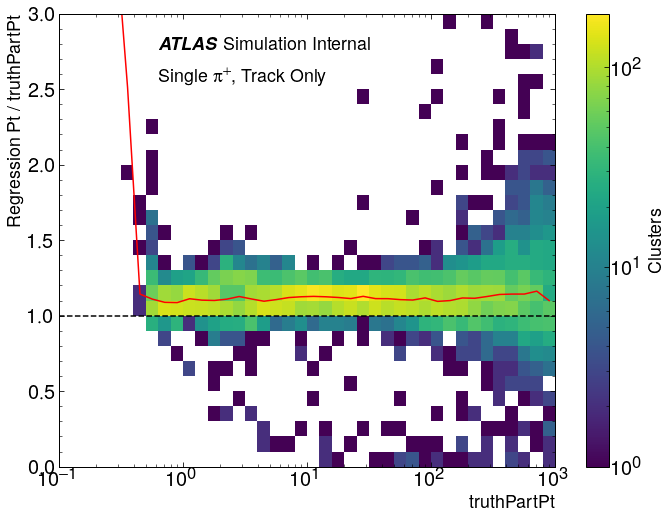

In [189]:
plotpath = '/home/russbate/MLPionCollaboration/LCStudies/clusters/Regression_Plots/'
Pt_center, Pt_Single = ru.responsePlot(pt_trth, 
                      pt_pred/pt_trth,
                      figfile = plotpath+'singleTrack_Pt_responsePlot.png', statistic = 'median',
                      xlabel = 'truthPartPt', ylabel = 'Regression Pt / truthPartPt',
                      atlas_x = 0.2, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.2, 'y': 0.85, 'text': 'Single $\pi^{+}$, Track Only'}])

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [medBase, medSingleBase, medReg, medRegSingle],
                labels = ['EM Scale, All Clusters', 'EM Scale, Single Clusters', 'Regressed, All Clusters', 'Regressed, Single Clusters'],
                xlabel = 'Cluster Calib Hits', ylabel = 'Cluster Energy / Calib Hits',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_profile_Overlay_BaseRegSingle.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$'},
                                  {'x': 0.5, 'y': 0.15,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.5, 'y': 0.1, 'text': 'Trained on All Clusters'}])

## Energy Target Plots

<Figure size 799.992x599.976 with 0 Axes>

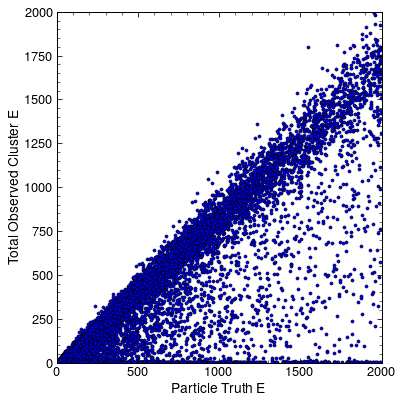

In [28]:
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.scatter(Y_truth, Y_clusterE, s=10,edgecolor='black', color='blue')
plt.xlabel('Particle Truth E', fontsize=14)
plt.ylabel('Total Observed Cluster E', fontsize=14)
# plt.title('truthPartE Against Observed Total', fontsize=18)
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('Plots/truthPartE_clusterE_2021-06-03.png', format='png')
plt.show()

<Figure size 799.992x599.976 with 0 Axes>

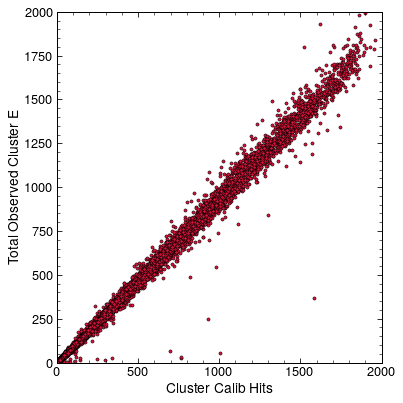

In [27]:
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.scatter(Y_eng, Y_clusterE, edgecolor='black', color='crimson', s=10)
# plt.title('cluster_ENG_CALIB_TOT Against Observed Total', fontsize=18)
plt.xlabel('Cluster Calib Hits', fontsize=14)
plt.ylabel('Total Observed Cluster E', fontsize=14)
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('Plots/cluster_ENG_CALIB_TOT_clusterE_2021-06-03.png', format='png')
plt.show()

#### 2-D Histogram - CLUSTERS

<ipython-input-44-3093ece74a51>:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist2d(Y_eng, Y_clusterE/Y_eng, bins=[xbin,ybin], norm=LogNorm())


<Figure size 432x288 with 0 Axes>

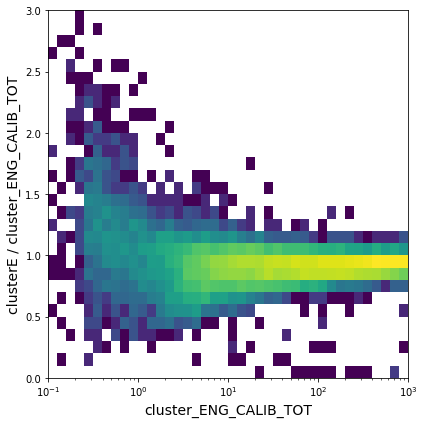

In [44]:
plt.cla(); plt.clf()

xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)

fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist2d(Y_eng, Y_clusterE/Y_eng, bins=[xbin,ybin], norm=LogNorm())
plt.xlabel('cluster_ENG_CALIB_TOT', fontsize=14)
plt.ylabel('clusterE / cluster_ENG_CALIB_TOT', fontsize=14)
plt.xscale('log')
# plt.tight_layout()
# plt.savefig('Plots/clusterE_cluster_ENG_CALIB_TOT_track_data_2021-06-03.png', format='png')
plt.show()

#### 2-D Histogram - TRUTH PARTICLE

<Figure size 432x288 with 0 Axes>

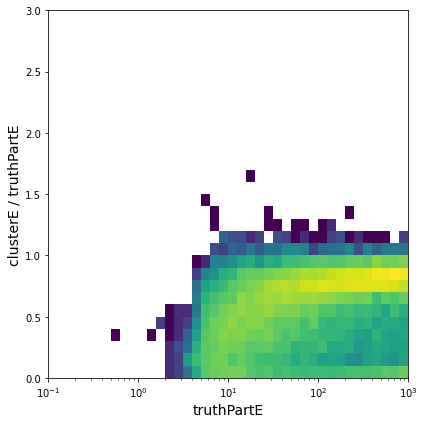

In [48]:
plt.cla(); plt.clf()

xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)

fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist2d(Y_truth, Y_clusterE/Y_truth, bins=[xbin,ybin], norm=LogNorm())
plt.xlabel('truthPartE', fontsize=14)
plt.ylabel('clusterE / truthPartE', fontsize=14)
plt.xscale('log')
# plt.tight_layout()
# plt.savefig('Plots/truthPartE_clusterE_track_data_2021-06-03.png', format='png')
plt.show()

## Particle Flow With Max's Data
### No tracks!

In [61]:
dat = np.load('/fast_scratch/atlas_images/v01-45/pipm_medium.npz')
print(dat.files)

['X', 'Y_label', 'Y_target']


In [62]:
X = dat['X']
Y_label = dat['Y_label']
Y_target = dat['Y_target']
print('X size: '+str(np.shape(X)))
print('Y_label size: '+str(np.shape(Y_label)))
print('Y_target size: '+str(np.shape(Y_target)))

X size: (122850, 2000, 3)
Y_label size: (122850, 2)
Y_target size: (122850,)


## Testing -- Ignore Below

#### Shallow Copy

In [204]:
myarray = np.arange(25).reshape((5,5))
print(myarray)
newarray = myarray[:,0]
print(newarray)
myarray[:,0] = np.exp(myarray[:,0])
print(newarray)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[ 0  5 10 15 20]
[        1       148     22026   3269017 485165195]


#### Deep Copy

In [205]:
myarray = np.arange(25).reshape((5,5))
print(myarray)
newarray = np.ndarray.copy(myarray[:,0])
print(newarray)
myarray[:,0] = np.exp(myarray[:,0])
print(newarray)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[ 0  5 10 15 20]
[ 0  5 10 15 20]
